<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/adversarial_example_iris_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO
- explanations and documentation
- rectangle plot
- upper bound for epsilon 
- Transpose?
- second example for fixed_input_y

# Neural network verification with z3

In this tutorial, the first step is to implement a machine learning model for image recognition using the python library pytorch. In the second step, the model is verified using the SMT solver z3.

Using pip, the z3 solver is downloaded and the required parts are imported from pytorch.

In [7]:
!nvidia-smi
%pip install z3-solver

Wed May 18 11:07:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
# imports for torch
import torch
from torch import nn
from torch.autograd import Variable

# imports for sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# import for progress bar
import tqdm

# numpy
import numpy as np

# for plots
import matplotlib.pyplot as plt

# for measuring runtime
import time

## Get Dataset

Training and test data must be available to train the ML model. These are downloaded from a public library and extracted via a DataLoader. 

In [4]:


iris = load_iris()
# print(iris_dataset)

X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']
  
print(f"Shape of X (data): {X.shape}")
print(f"Shape of y (target): {y.shape} {y.dtype}")
print(f"Example of x and y pair: {X[0]} {y[0]}")

# Scale data to have mean 0 and variance 1 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

print("Shape of training set X", X_train.shape)
print("Shape of test set X", X_test.shape)

Shape of X (data): (150, 4)
Shape of y (target): (150,) int64
Example of x and y pair: [5.1 3.5 1.4 0.2] 0


## Visualize

In [45]:
plt.style.use('ggplot')

def show_plots(X, y, fixed_input_y = None, epsilon = None):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax1.plot(X_plot[:, 0], X_plot[:, 1], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax1.set_xlabel(feature_names[0])
  ax1.set_ylabel(feature_names[1])
  ax1.axis('equal')
  ax1.legend()

  for target, target_name in enumerate(names):
      X_plot = X[y == target]
      ax2.plot(X_plot[:, 2], X_plot[:, 3], 
              linestyle='none', 
              marker='o', 
              label=target_name)
  ax2.set_xlabel(feature_names[2])
  ax2.set_ylabel(feature_names[3])
  ax2.axis('equal')
  ax2.legend()

  if fixed_input_y is not None and epsilon is not None:
    # TODO add rectangle (l infinitiy norm) +-epsilon
    circle = plt.Circle((X[0][0], X[0][1]), 0.2, color='r', fill=False)
    ax1.set_aspect("equal", adjustable="datalim")
    ax1.add_patch(circle)

    circle = plt.Circle((X[0][2], X[0][3]), 0.2, color='r', fill=False)
    ax2.set_aspect("equal", adjustable="datalim")
    ax2.add_patch(circle)

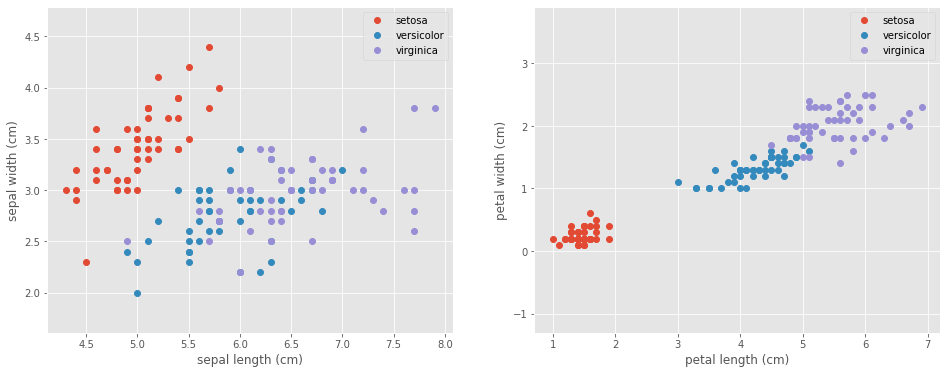

In [5]:
show_plots(X, y)

## Create Model

The class NeuralNetwork(nn.Module) allows initializing a neural network with different layers. 
Here, we use a simple network with only two linear layers, because complex networks as complex networks require a high computational effort for verification.

In [10]:
import torch.nn.functional as F
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, number_of_neurons):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, number_of_neurons),
            nn.ReLU(),
            nn.Linear(number_of_neurons, output_dim),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

Using cuda device


## Train model

An instance of the class NeuralNetwork() is then created and trained by using an optimizer and loss function.

In [11]:
def train(X, y, model, loss_fn, optimizer):
    model.train()
    
    # convert numpy array to pytorch tensor
    X = Variable(torch.from_numpy(X)).float()
    y = Variable(torch.from_numpy(y)).long()
    X = X.to(device)
    y = y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss = loss.item()
    return loss

def predict(X, model):
    model.eval()
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        X = X.to(device)
        pred = model(X)
        pred = pred.argmax(1)
        pred = pred.cpu().detach().numpy()
    return pred

def test(X, y, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        X = Variable(torch.from_numpy(X)).float()
        y = Variable(torch.from_numpy(y)).long()
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    correct /= X.shape[0]
    return correct, test_loss

In [29]:
def train_model(model, epochs):
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


  loss_list     = np.zeros((epochs,))
  accuracy_list = np.zeros((epochs,))

  for epoch in tqdm.trange(epochs):
    loss_list[epoch] = train(X_train, y_train, model, loss_fn, optimizer)
    correct, test_loss = test(X_test, y_test, model, loss_fn)
    accuracy_list[epoch] = correct
  
  print()
  print("Done. Accuracy:", accuracy_list[-1])

In [30]:
torch.manual_seed(42)

model = NeuralNetwork(input_dim=X_train.shape[1], output_dim=3, number_of_neurons=20).to(device)
print(model)

train_model(model, epochs=100)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=3, bias=True)
  )
)


100%|██████████| 100/100 [00:00<00:00, 179.46it/s]


Done. Accuracy: 0.9


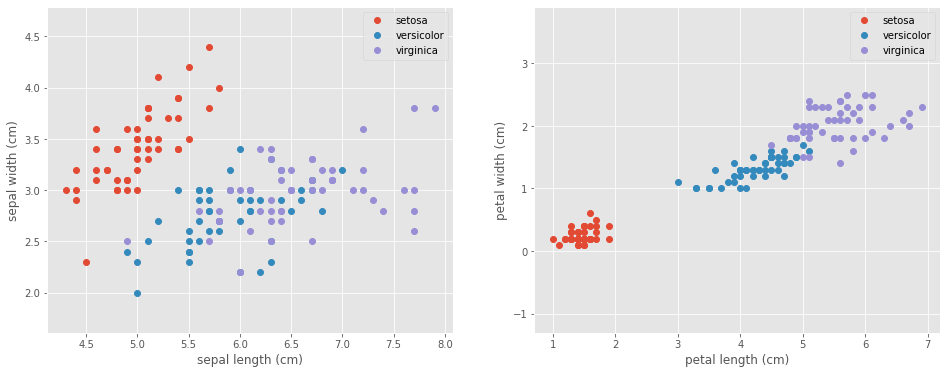

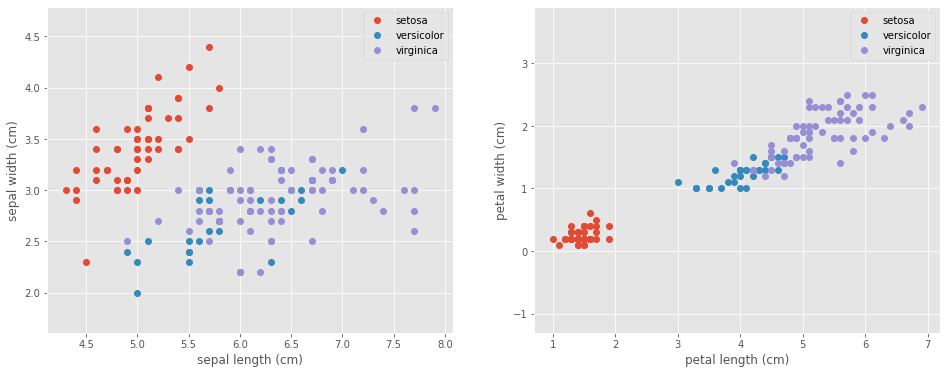

In [32]:
show_plots(X, y)
show_plots(X, predict(X, model))

## Verification of a neural network using Z3

The next step will be to create a solver with z3 in order to find Aversarial Examples. "An adversarial example is an instance with small, intentional feature perturbations that cause a machine learning model to make a false prediction." (For more information on adversarial examples see [this article](https://christophm.github.io/interpretable-ml-book/adversarial.html).
Z3 is a theorem prover from Microsoft Research (for more information on z3 see [z3 on pypi](https://pypi.org/project/z3-solver/)). 

We first need to import the numpy and z3 library.

In [35]:
import numpy as np
from z3 import *

The ML model was trained on the MNIST dataset in the previous section.
Now the task is to recreate the model using the trained weights and the layers of the model. To do this, the learned weights and biases must first be extracted from the model. This is done by iterating over the layers and saving the weights and biases of the Linear Layers into lists.

In [36]:
def get_weights_and_biases_pytorch(model):
  weights_and_biases = [param.cpu().detach().numpy() for param in model.parameters()]
  weights = weights_and_biases[0::2]
  biases = weights_and_biases[1::2]
  return weights, biases


weights, biases = get_weights_and_biases_pytorch(model)

To analyze the network with z3 later on, we have to manually define our activation function which in our case is the Relu function as our solver can only deal with (partially) linear activation functions. In the same way the absolute value is defined as a helper function to aid in calculating the distance between 2 vectors when using z3.

In [37]:
def Relu(x):
    return np.vectorize(lambda y: If(y >= 0 , y, RealVal(0)))(x)


def Abs(x):
    ret = If(x <= 0, -x, x)
    return ret

In the following function the model is defined. 
The input x are z3 variables. They iterate through each layer with the previously extracted weights and biases. 
This results in a z3 formula with the z3 inputs.

TODO: check transpose

x @ np.transpose(weights) ???

In [39]:
def net(x, weights, biases):
  output = x

  for i, (weight, bias) in enumerate(zip(weights, biases)):
    output = weight @ output + bias
    # apply relu except in last layer
    if i != len(weights) - 1:
      output = Relu(output)
  return output

In the next section we search the adversarial example to a sample of the dataset. Therefore a sample runs through the trained model to predict an outcome. 
The beforehand written function ```net(x)``` gets a manipulated input of the sample. A epsilon is added to every value of the input of the function.
To generate a vector epsilon which will constitute our manipulation of the input data with z3 the solver has to be defined first and then the constraints of our vectors as well as the inputs and outputs are added to the solver. The solver then has to check the satisfiability of the given constraints and a model is returned and printed if a vector epsilon which has a taxicab norm smaller than the constant e and changes the category with the highest probability exists.

## Robustness verification

Adversarial robustness with fixed input $\vec{y} ∈ R^m $, L∞-distance, 𝑉_𝑖={𝜈_1, …, 𝜈_𝑚 }, and 𝑉_𝑜={𝜈_1^′, …, 𝜈_𝑛^′ }:

verification condition: $ \psi≔(φ_{pre} ∧ φ_{assign}) ⇒ φ_{post} $

precondition: $ \varphi_{pre} ≔ ⋀_{i=1}^n ((x_{v_i} - y_i ≤ ε) ∧ (y_i - x_{v_i} ≤ ε)) $

assign: $ \varphi_{assign} ≔ φ^N $

post condition: $ \varphi_{post} ≔ ⋀_{i=1}^m x_{v'_i} ≤ x_{v'_l} $ for $ \ell = \arg\max f_N(\vec{y}) $


proving robustness means proving the verification condition

In [41]:
def verify(fixed_input_y, fixed_input_y_class, epsilon, weights, biases):
  """assumption: the model to verify has only fully connected layers with bias in every layer and relu between them"""
  input_size = fixed_input_y.shape[0]
  x = RealVector("x", input_size)

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)

  # post-condition
  # x_vo = x_v'
  output = net(x, weights, biases)
  and_parts = []
  for i, x_vo in enumerate(output):
    and_parts.append(x_vo <= output[fixed_input_y_class])
  post_cond = And(and_parts)

  verification_cond = Implies(pre_cond, post_cond)

  print("Pre condition: ")
  print(pre_cond)
  print("Post condition: ")
  print(post_cond)
  print("--------------")

  prove(verification_cond)

TODO add second fixed input example

In [42]:
fixed_input_y = X[0]
fixed_input_y_class = y[0]
epsilon = 0.5

In [ ]:
start_time = time.time()
verify(fixed_input_y, fixed_input_y_class, epsilon, weights, biases)
print(f"{((time.time() - start_time)/60):.2f} minutes")

## Prediction plots with epsilon

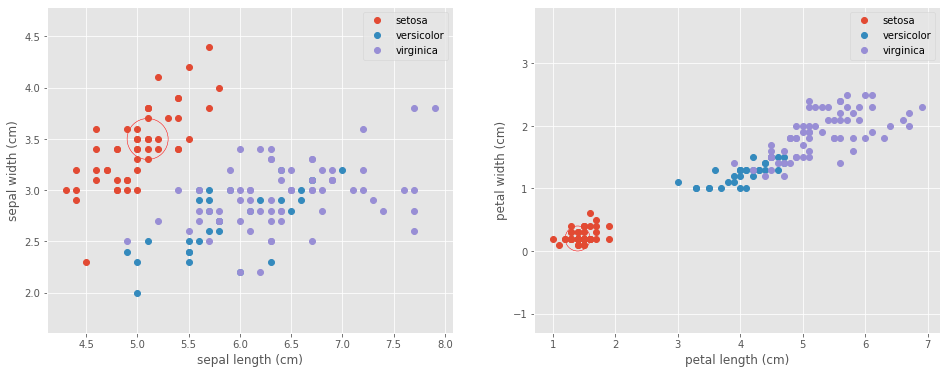

In [44]:
show_plots(X, predict(X, model), fixed_input_y, epsilon)

## Task: find largest epsilon for robustness with binary search
with a certain accuracy

TODO

## Appendix

### Verify with each neuron encoded seperately

In [ ]:
def ReluSingleNeuron(x):
  return If(x >= 0, x, RealVal(0))

def verify_each_neuron(fixed_input_y, fixed_input_y_class, epsilon, weights, biases):
  # Unpack weights of the trained model
  input_size = fixed_input_y.shape[0]
  neurons = []
  x = RealVector("x", input_size)
  output  = [RealVector(f"x{i}", weight.shape[0]) for i, weight in enumerate(weights)]

  # pre-condition
  # basically L_infinity-distance in boolean speak
  and_parts = []
  for i, x_vi in enumerate(x):
    and_parts.append(And((x_vi - fixed_input_y[i]) <= epsilon, (fixed_input_y[i] - x_vi) <= epsilon))
  pre_cond = And(and_parts)
  #print(pre_cond)

  # assign
  and_parts = []
  # for each layer
  for layer_i, (layer_output, layer_weights, layer_biases) in enumerate(zip(output, weights, biases)):
    # for each neuron
    for neuron_output, neuron_weights, neuron_bias in zip(layer_output, layer_weights, layer_biases):
      if layer_i == 0:
        # neuron input is net input
        neuron_inputs = x
      else:
        # neuron input is output of previous layer
        neuron_inputs = output[layer_i - 1]
      and_parts.append(neuron_output == ReluSingleNeuron(neuron_weights @ neuron_inputs + neuron_bias))
  assign = And(and_parts)

  # post-condition
  # x_vo = x_v'
  and_parts = []
  for i, x_vo in enumerate(output[-1]):
    # l is the argmax of fixed_input_y
    and_parts.append(x_vo <= output[-1][fixed_input_y_class])
  post_cond = And(and_parts)

  # verification conditions
  verification_cond = Implies(And(pre_cond, assign), post_cond)

  # prove using Z3
  prove(verification_cond)

In [ ]:
start_time = time.time()
verify_each_neuron(fixed_input_y, fixed_input_y_class, epsilon, weights, biases)
print(f"{((time.time() - start_time)/60):.2f} minutes")

### Another approach: Create Solver to find Adversarial Examples

In [ ]:
def find_adversarial_example(num, s):
   # predict outcome of inputs with network
    sample = Variable(torch.from_numpy(X_test[num])).float()
    y1 =  torch.argmax(model(sample)).tolist()
    if (y1 == y_test[num]):
      print("The ML model predicted the correct flower.")
    else:
      print("The ML model predicted the wrong flower, for a correct example rerun the script.")

    epsilon = RealVector('epsilon', 4)
    # new sample with a little difference e (adversarial example)
    new_X = [x + e for (x, e) in zip(sample.cpu().detach().numpy(), epsilon)]
    y2_pred = net(new_X)

    s.push()
    e = 1
    s.add(Sum([Abs(a) for a in epsilon]) < e)
    # does work :
    # s.add(torch.argmax(y1).cpu().detach().numpy() != y2_pred)
    s.add(Or(y2_pred[0] > y2_pred[y1], y2_pred[1] > y2_pred[y1], y2_pred[2] > y2_pred[y1]))
    res = s.check()
    print(res)
    if res == sat:
        m = s.model()
        print(m)
    s.pop()

In [ ]:
for i in range(len(X_test)):
  s = Solver()
  find_adversarial_example(i, s)